#  Deep Learning for Super Resolution on DestinE Climate Data

Destine Login

In [ ]:
%%capture cap
%run auth/cacheb-authentication.py

In [ ]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Import dependencies

In [179]:
import warnings
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from utils.general import (get_bbox_from_config,
                           load_config, compute_mean_std,
                           create_gif_from_images,
                           save_best_model_as_pt,
                           save_config_to_log_dir)
from data.loaders import load_data
from data.datasets import CreateDataset, StreamCreateDataset
import models.models as models
from trainer import TrainerSr
# Ignore warnings and set precision
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('high')

### 1. Load Configuration

In [180]:
# Load configuration and set seed
config = load_config()
seed_everything(config["training"]["seed"], workers=True)

Seed set to 42


42

In [ ]:
import xarray as xr


def load_data(config):
    """
    Load low-resolution (LR) and high-resolution (HR) data based on the configuration.

    Args:
        config (dict): Configuration dictionary containing dataset paths and other settings.

    Returns:
        lr (xarray.DataArray): Low-resolution dataset.
        hr (xarray.DataArray): High-resolution dataset.
    """

    lr_data = xr.open_dataset(
        config["dataset"]["lr_zarr_url"],
        engine="zarr",
    storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )

    lr_data = lr_data[config["dataset"]["data_variable"]]
    lr_data = lr_data.astype("float32")
    latitude_range = tuple(config["dataset"]["latitude_range"])
    longitude_range = tuple(config["dataset"]["longitude_range"])

    lr = lr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))
    lr = lr.sel(time=config["dataset"]["time_range"]).load()
    # Load high-resolution data
    hr_data = xr.open_dataset(
        config["dataset"]["hr_zarr_url"],
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
    hr_data = hr_data[config["dataset"]["data_target"]]
    hr_data = hr_data.astype("float32")
    hr = hr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))
    hr = hr.sel(time=config["dataset"]["time_range"])

    hr.attrs["units"] = config["dataset"]["unit"]
    lr.attrs["units"] = config["dataset"]["unit"]
    if config["training"]["streaming"]:
        return lr, hr
    else:

        return lr.load(), hr.load()

### 2. Load Data and Compute Statistics


In [185]:
# Load bounding box and data
bbox = get_bbox_from_config(config=config)
lr, hr = load_data(config=config)

In [186]:
size_in_mb = lr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

Dataset size: 26.16 MB


In [187]:
size_in_mb = hr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

Dataset size: 186.01 MB


In [188]:

# # Compute mean and standard deviation for normalization
# hr_mean, hr_std = compute_mean_std(hr)
# lr_mean, lr_std = compute_mean_std(lr)

# # Update config with computed mean and std
# config["dataset"]["hr_mean"] = hr_mean
# config["dataset"]["hr_std"] = hr_std
# config["dataset"]["lr_mean"] = lr_mean
# config["dataset"]["lr_std"] = lr_std

# # Display computed statistics
# print(f"HR mean: {hr_mean}, HR std: {hr_std}")
# print(f"LR mean: {lr_mean}, LR std: {lr_std}")

### 3. Split Data into Train, Validation, and Test Sets

In [189]:
# Split indices for train, validation, and test sets
batch_size = config['training']['batch_size']
time_indices = np.arange(len(hr.time.values))

train_indices, remaining_indices = train_test_split(
    time_indices, train_size=0.70, shuffle=True, random_state=config["training"]["seed"]
)
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=config["validation"]["val_split_ratio"], shuffle=False, random_state=config["training"]["seed"]
)

# Split datasets into train, validation, and test sets
train_lr, train_hr = lr.isel(time=train_indices), hr.isel(time=train_indices)
val_lr, val_hr = lr.isel(time=val_indices), hr.isel(time=val_indices)
test_lr, test_hr = lr.isel(time=test_indices), hr.isel(time=test_indices)

# Print dataset sizes
print(f"Train samples: {len(train_hr.time.values)}")
print(f"Validation samples: {len(val_hr.time.values)}")
print(f"Test samples: {len(test_hr.time.values)}")

Train samples: 520
Validation samples: 156
Test samples: 68


In [192]:
## Feature-wise Normalization
variables = list(lr.data_vars)

def normalize_xarray(dataset, variables):
    """
    Normalize an xarray dataset feature-wise for each time index.

    Args:
        dataset (xr.Dataset): Input xarray dataset
        variables (list): List of variable names to normalize

    Returns:
        xr.Dataset: Normalized dataset
    """
    normalized_data = {}

    for v in variables:
        # Compute mean & std for each time step independently
        mean = dataset[v].mean(dim=["latitude", "longitude"])
        std = dataset[v].std(dim=["latitude", "longitude"])

        # Normalize feature-wise per time step
        normalized_data[v] = (dataset[v] - mean) / std

    # Return as a new xarray dataset
    return xr.Dataset(normalized_data, coords=dataset.coords)

# Example usage
normalized_lr = normalize_xarray(lr, variables)

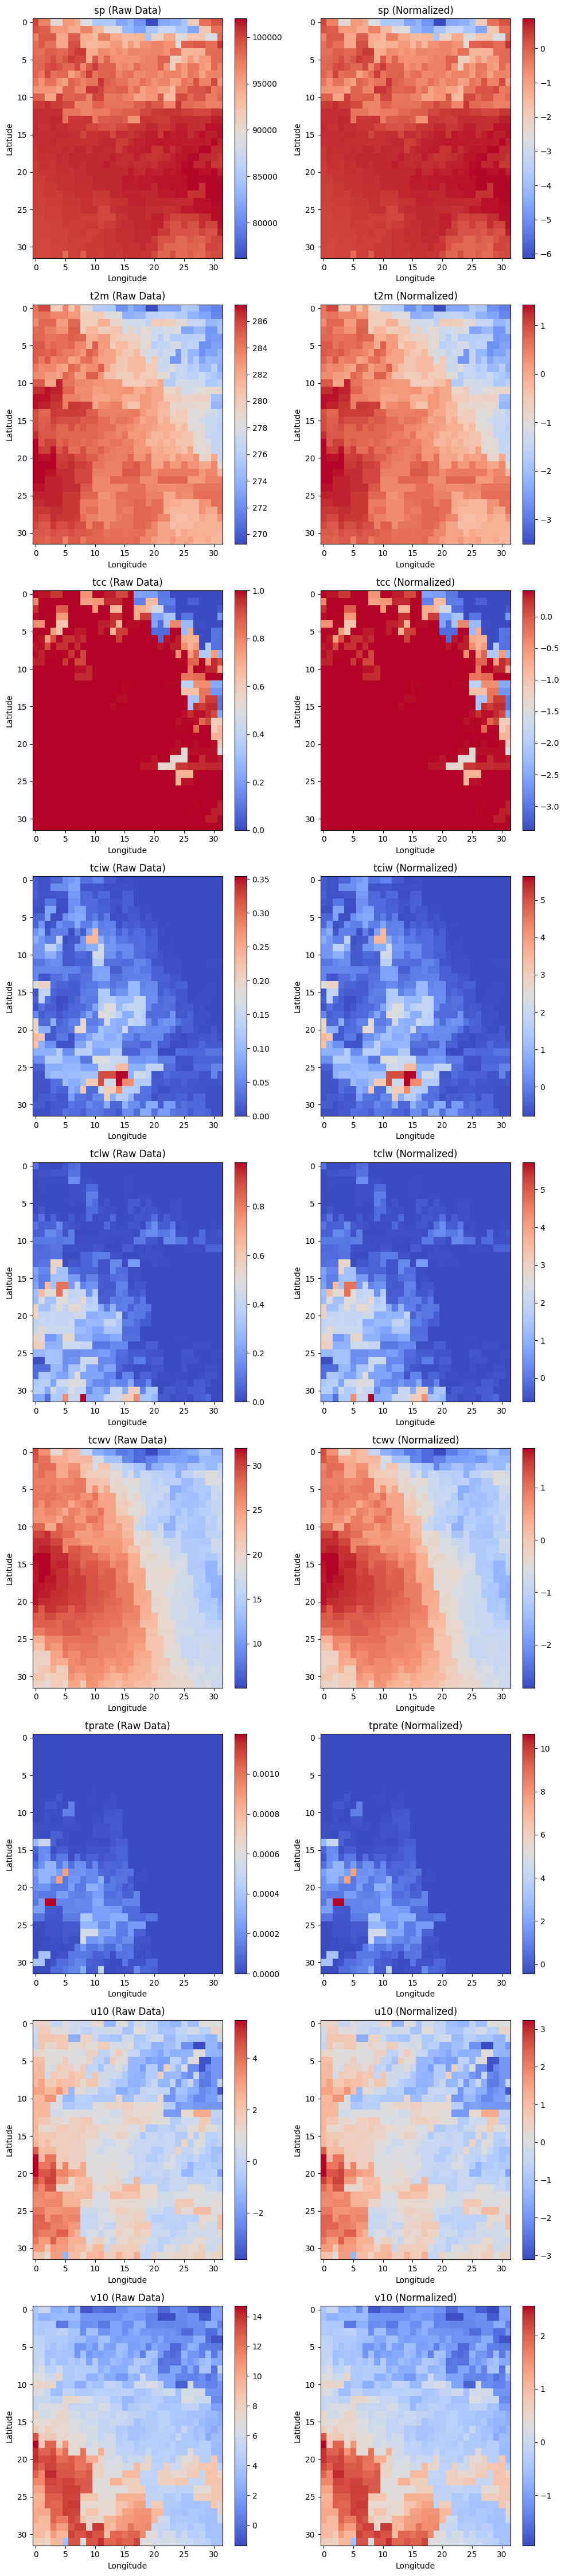

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Select a specific time index (e.g., first time step)
time_idx = 10

# Create subplots (2 columns: before & after normalization)
fig, axes = plt.subplots(len(variables), 2, figsize=(10, 5 * len(variables)))

for i, v in enumerate(variables):
    # Extract data for the variable at the given time step
    tmp_data = train_lr[v].isel(time=time_idx)

    # Compute mean & std for normalization
    mean = tmp_data.mean().values
    std = tmp_data.std().values
    normalized = (tmp_data.values - mean) / std

    # Plot original data
    ax1 = axes[i, 0] if len(variables) > 1 else axes[0]
    im1 = ax1.imshow(tmp_data, cmap="coolwarm", aspect="auto")
    ax1.set_title(f"{v} (Raw Data)")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    fig.colorbar(im1, ax=ax1)

    # Plot normalized data
    ax2 = axes[i, 1] if len(variables) > 1 else axes[1]
    im2 = ax2.imshow(normalized, cmap="coolwarm", aspect="auto")
    ax2.set_title(f"{v} (Normalized)")
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    fig.colorbar(im2, ax=ax2)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [195]:
## Feature-wise Normalization
variables = list(lr.data_vars)

def proprocessing(dataset, variables):
    """
    Normalize an xarray dataset feature-wise for each time index.

    Args:
        dataset (xr.Dataset): Input xarray dataset
        variables (list): List of variable names to normalize

    Returns:
        xr.Dataset: Normalized dataset
    """
    normalized_data = {}

    for v in variables:
        # Compute mean & std for each time step independently
        mean = dataset[v].mean(dim=["latitude", "longitude"])
        std = dataset[v].std(dim=["latitude", "longitude"])

        # Normalize feature-wise per time step
        normalized_data[v] = (dataset[v] - mean) / std

    # Return as a new xarray dataset
    return xr.Dataset(normalized_data, coords=dataset.coords)

 Subplot to Compare Normalized Data

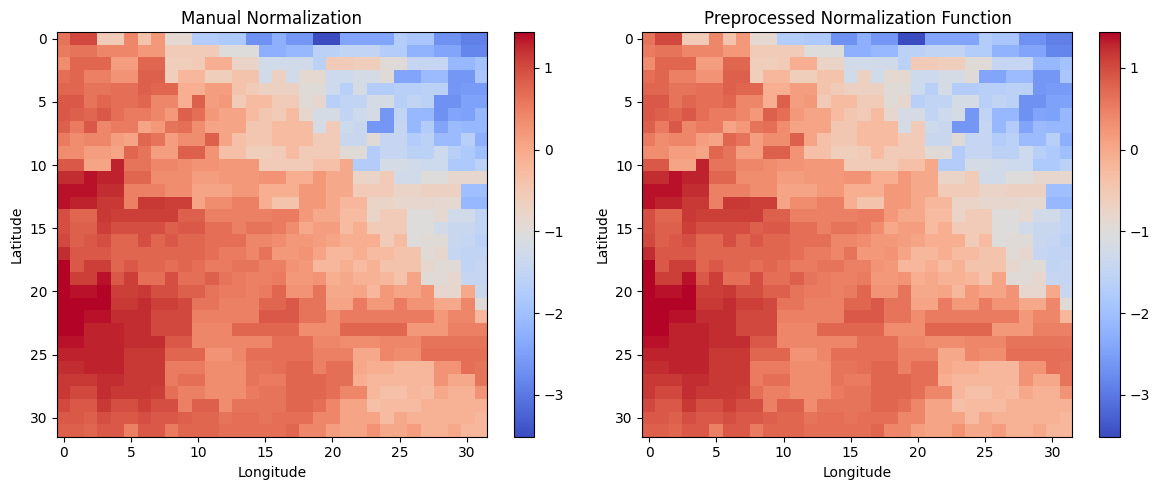

In [242]:
# Extract manually normalized data
time_idx = 10
tmp_data = train_lr["t2m"].isel(time=time_idx)
mean = tmp_data.mean().values
std = tmp_data.std().values
manual_normalized = (tmp_data.values - mean) / std

normalized_xarray = proprocessing(dataset=train_lr, variables=variables)
auto_normalized = normalized_xarray["t2m"].isel(time=time_idx).values

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot manually normalized data
im1 = axes[0].imshow(manual_normalized, cmap="coolwarm", aspect="auto")
axes[0].set_title("Manual Normalization")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
fig.colorbar(im1, ax=axes[0])

# Plot preprocessed normalized data
im2 = axes[1].imshow(auto_normalized, cmap="coolwarm", aspect="auto")
axes[1].set_title("Preprocessed Normalization Function")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
fig.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

In [197]:
print((auto_normalized - manual_normalized ).mean())
print((auto_normalized - manual_normalized ).std())
print((auto_normalized - manual_normalized ).max())
print((auto_normalized - manual_normalized ).min())

0.0
0.0
0.0
0.0


### 4. Create DataLoader

In [246]:
train_dataset = CreateDataset(hr_data=train_hr, lr_data=train_lr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)


In [247]:
import torch

def z_score_normalization(tensor):
    """
    Perform Z-score normalization for each channel of the input tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape [B, C, H, W]

    Returns:
        torch.Tensor: Normalized tensor
    """
    # Calculate the mean and std for each channel (C) across the spatial dimensions (H, W)
    mean = tensor.mean(dim=[2, 3], keepdim=True)  # Mean along H and W for each channel
    std = tensor.std(dim=[2, 3], keepdim=True)    # Standard deviation along H and W for each channel
    # Perform Z-score normalization for each channel
    normalized_tensor = (tensor - mean) / std

    return normalized_tensor

In [248]:
for data in train_loader:
    low_res, high_res = data
    print(f" lr: {low_res.shape} - hr: {high_res.shape}")

 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) - hr: torch.Size([32, 1, 256, 256])
 lr: torch.Size([32, 9, 32, 32]) -

In [223]:
# # Create DataLoader based on streaming preference
# if config["training"]["streaming"]:
#     train_loader = StreamCreateDataset(hr_data=train_hr, lr_data=train_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                        lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
#     val_loader = StreamCreateDataset(hr_data=val_hr, lr_data=val_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                      lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
#     test_loader = StreamCreateDataset(hr_data=test_hr, lr_data=test_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                       lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
# else:
#     train_dataset = CreateDataset(hr_data=train_hr, lr_data=train_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                   lr_mean=lr_mean, lr_std=lr_std)
#     val_dataset = CreateDataset(hr_data=val_hr, lr_data=val_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                 lr_mean=lr_mean, lr_std=lr_std)
#     test_dataset = CreateDataset(hr_data=test_hr, lr_data=test_lr, hr_mean=hr_mean, hr_std=hr_std,
#                                  lr_mean=lr_mean, lr_std=lr_std)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)


### 5. Initialize Model


In [ ]:
# Initialize SRResNet model based on config
sr_model = getattr(models, config["model"]["architecture"])
sr_model = sr_model(
    large_kernel_size=config["model"]["large_kernel_size"],
    small_kernel_size=config["model"]["small_kernel_size"],
    n_channels=config["model"]["n_channels"],
    n_blocks=config["model"]["n_blocks"],
    scaling_factor=config["model"]["scaling_factor"]
)

# Wrap model in TrainerSr class
model = TrainerSr(config=config, model=sr_model)

### 6. Set Up Checkpointing and Trainer


In [ ]:
# Define checkpoint callback
checkpoint_val_ssim = ModelCheckpoint(
    monitor=config['checkpoint']['monitor'], filename="best-val-ssim-{epoch:02d}-{val_ssim:.2f}",
    save_top_k=1, mode=config['checkpoint']['mode']
)

# Set up the PyTorch Lightning Trainer
trainer = L.Trainer(
    devices=config["training"]["devices"],
    max_epochs=config["training"]["epochs"],
    accelerator=config["training"]["accelerator"],
    deterministic=config["training"]["deterministic"],
    callbacks=[checkpoint_val_ssim],
)


### 7. Train the Model


In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)

### 8. Evaluate and Test the Model


In [ ]:
# Load best model checkpoint
best_model_path = checkpoint_val_ssim.best_model_path
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["state_dict"])

# Test the model
trainer.test(model, test_loader)

### 9. Visualize Results and Save Model


In [ ]:
# Generate visualizations and create GIF
create_gif_from_images(trainer=trainer)

# Save best model as .pt file
best_model_path = save_best_model_as_pt(checkpoint_val_ssim, sr_model)

# Save config to log directory
save_config_to_log_dir(log_dir_path=trainer.log_dir, config=config)

### 10. Inference

In [ ]:
from inference import SuperResolutionInference
sr_model = getattr(models, config["model"]["architecture"])
sr_model = sr_model(
    large_kernel_size=config["model"]["large_kernel_size"],
    small_kernel_size=config["model"]["small_kernel_size"],
    n_channels=config["model"]["n_channels"],
    n_blocks=config["model"]["n_blocks"],
    scaling_factor=config["model"]["scaling_factor"]
)
# Initialize the inference class
sr = SuperResolutionInference(model_path=best_model_path, model_class=sr_model)

# Load and preprocess a single LR image
lr_image = lr.sel(time="2024-10-15T12:00:00")
preprocessed_image = sr.preprocess(lr_image, lr_mean=lr_mean, lr_std=lr_std)

# Perform inference
sr_result = sr.inference(preprocessed_image)

# Post-process the SR result
sr_result = sr.postprocessing(sr_result, hr_mean, hr_std)
# Visualize the LR and SR images
fig = sr.visualize(lr_image=lr_image, sr_image=sr_result, lr_time=lr_image.time.values)